In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\gfg2\Solar-Panel-Optimization\solar_data.csv')

In [3]:
df.head()

,YEAR,MO,DY,HR,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DWN,ALLSKY_KT,ALLSKY_SRF_ALB,SZA,QV2M,T2M,WS10M
0,2021,1,1,5,0.00,0.00,-999.00,-999.00,-999.00,8.30,13.89,2.52
1,2021,1,1,6,0.00,0.00,-999.00,-999.00,-999.00,8.61,13.69,2.54
2,2021,1,1,7,42.30,38.66,0.23,0.17,83.07,8.91,15.23,2.63
3,2021,1,1,8,170.27,167.65,0.38,0.01,71.55,9.09,17.99,3.12
4,2021,1,1,9,326.15,321.80,0.48,0.03,61.27,9.34,21.03,2.11


In [4]:
df.shape

(26304, 12)

In [5]:
def cal_zenith_angle(row):

    if row['SZA'] != -999:
        return row['SZA']
    
    day = row['DY']
    hour = row['HR']
    
    delta = 23.45 * math.sin(360 * (day - 80) / 365) # declination angle
    omega = 15 * (hour - 12) # hour angle
    theta =  math.acos((math.sin(23.03) * math.sin(delta)) + (math.cos(23.03) * math.cos(delta) * math.cos(omega)))
    return 90 - theta
    

In [6]:
df['new_SZA'] = df.apply(lambda x: cal_zenith_angle(x), axis=1)

In [7]:
df['tilt'] = 90 - df['new_SZA']
df.drop(['SZA', 'new_SZA'], axis=1, inplace=True)

In [8]:
df

,YEAR,MO,DY,HR,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DWN,ALLSKY_KT,ALLSKY_SRF_ALB,QV2M,T2M,WS10M,tilt
0,2021,1,1,5,0.00,0.00,-999.00,-999.00,8.30,13.89,2.52,0.604639
1,2021,1,1,6,0.00,0.00,-999.00,-999.00,8.61,13.69,2.54,0.514336
2,2021,1,1,7,42.30,38.66,0.23,0.17,8.91,15.23,2.63,6.930000
3,2021,1,1,8,170.27,167.65,0.38,0.01,9.09,17.99,3.12,18.450000
4,2021,1,1,9,326.15,321.80,0.48,0.03,9.34,21.03,2.11,28.730000
...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2024,1,2,0,-999.00,-999.00,-999.00,-999.00,7.02,15.79,2.89,2.676108
26300,2024,1,2,1,-999.00,-999.00,-999.00,-999.00,7.32,15.14,2.85,2.604174
26301,2024,1,2,2,-999.00,-999.00,-999.00,-999.00,7.75,14.54,2.81,2.513745
26302,2024,1,2,3,-999.00,-999.00,-999.00,-999.00,8.18,13.98,2.80,2.737444


In [9]:
df = df[(df['CLRSKY_SFC_SW_DWN'] != -999) & (df['ALLSKY_SFC_SW_DWN'] != -999) & (df['ALLSKY_KT'] != -999) & (df['ALLSKY_SRF_ALB'] != -999)]

In [10]:
df.reset_index(inplace=True)

In [11]:
df.drop(['index'], axis=1, inplace=True)

In [12]:
df.shape

(13363, 12)

In [13]:
correlation = df.corr()

<Axes: >

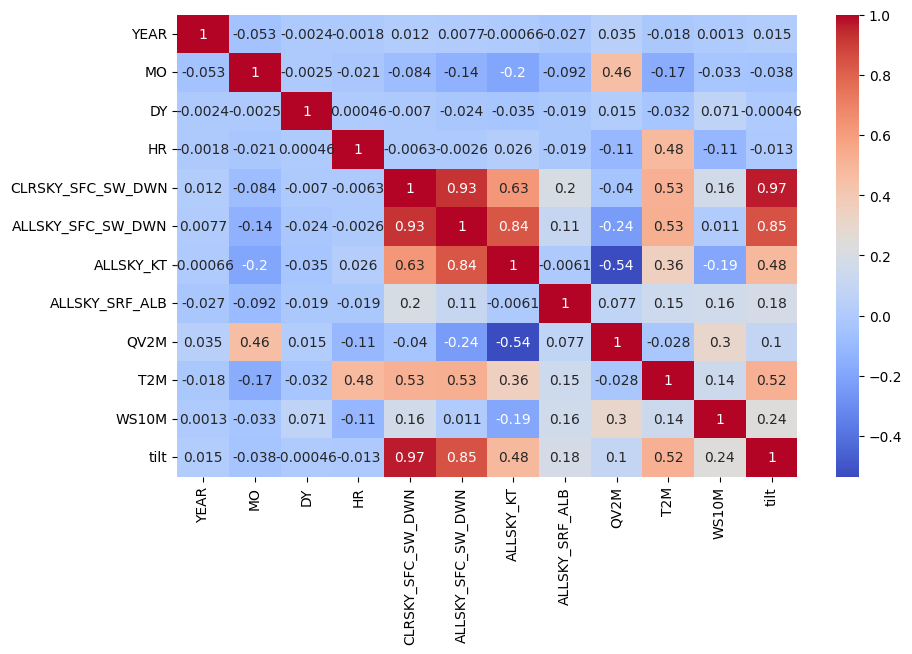

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [15]:
pip install xgboost

In [16]:
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import math

In [17]:
data_df = df.drop(['tilt'], axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data_df, df["tilt"], random_state=42, test_size=0.20)

In [19]:
size_scaler = StandardScaler().fit(X_train)

In [20]:
X_train_scaled = size_scaler.transform(X_train)
X_test_scaled = size_scaler.transform(X_test)

In [21]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=12345),
    'Random Forest': RandomForestRegressor(random_state=12345),
    'XGB': XGBRegressor(random_state=12345, tree_method="hist"),
}

In [22]:
score_type = ['neg_mean_absolute_error', 'neg_mean_squared_error']

In [23]:
model_results = pd.DataFrame()
for m in ['Train_MAE', 'Val_MAE', 'Train_RMSE', 'Val_RMSE', 'test_MAE', 'test_RMSE']:
    model_results[m] = None

In [24]:
for model_name, model in models.items():
    score = cross_validate(model, X_train_scaled, y_train, cv=5, scoring=score_type, return_train_score=True)

    train_mae = (-score['train_neg_mean_absolute_error']).mean()
    val_mae = (-score['test_neg_mean_absolute_error']).mean()
    train_rmse = np.sqrt(-score['train_neg_mean_squared_error']).mean()
    val_rmse = np.sqrt(-score['test_neg_mean_squared_error']).mean()

    res = model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    # test_rmse = np.mean(((predictions - y_test) ** 2))
    test_rmse = mean_squared_error(y_test, predictions)
    test_mae = mean_absolute_error(y_test, predictions)
    model_results.loc[model_name] = [train_mae, val_mae, train_rmse, val_rmse,test_mae, test_rmse]

In [25]:
model_results

,Train_MAE,Val_MAE,Train_RMSE,Val_RMSE,test_MAE,test_RMSE
Linear Regression,2.907060e+00,2.911017,3.844633e+00,3.849043,3.011878,16.150693
Decision Tree,5.317439e-18,0.737065,1.552456e-16,1.586353,0.713105,2.753642
Random Forest,1.974907e-01,0.520337,3.871434e-01,1.010248,0.518234,1.366886
XGB,3.050263e-01,0.675254,4.158595e-01,1.028687,0.645650,1.080067


In [26]:
model_dict = {
    'Random Forest': {'model': RandomForestRegressor(random_state=12345, n_jobs=-1), 
                      'params': {'n_estimators': list(range(5, 50, 5)), 'min_samples_split': [2, 5, 10]}},
    'XGB': {'model': XGBRegressor(random_state=12345, n_jobs=-1),
            'params': {'max_depth': [6, 7, 9], 'n_estimators': list(range(5, 50, 5)), 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                        'subsample': [0.2, 0.3, 0.4], 'gamma': [0, 0.5, 0.6, 0.7], 'reg_lambda': [0, 1, 5, 10]}}
}

In [27]:
def hyperparameter_tuning():
    best_model = None
    best_score = -math.inf

    for model_name, reg_model in model_dict.items():
        hyper_tuning_model = RandomizedSearchCV(reg_model['model'], reg_model['params'], n_iter=10, cv=5, return_train_score=True, verbose=0, scoring=score_type, refit='neg_mean_squared_error')
        hyper_tuning_model.fit(X_train_scaled, y_train)

        model_res = hyper_tuning_model.best_estimator_
        best_model_score = hyper_tuning_model.best_score_

        res = hyper_tuning_model.cv_results_

        print(model_name, ":: ", best_model_score, hyper_tuning_model.best_params_)

        if best_model_score > best_score:
            best_score = best_model_score
            best_model = model_res

    print('Best Model :: ', best_model)

    return best_model

In [28]:
best_model = hyperparameter_tuning()

Random Forest ::  -1.0674460911482693 {'n_estimators': 40, 'min_samples_split': 2}
XGB ::  -1.593372747960383 {'subsample': 0.4, 'reg_lambda': 10, 'n_estimators': 40, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0.5}
Best Model ::  RandomForestRegressor(n_estimators=40, n_jobs=-1, random_state=12345)


In [29]:
np.mean(((best_model.predict(X_test_scaled) - y_test) ** 2))

1.380536691194351

In [30]:
df['date_time_str'] = df.apply(lambda x: f"{int(x['MO'])}/{int(x['DY'])}/{int(x['YEAR'])} {int(x['HR'])}:00:00", axis=1)
df['date_time'] = pd.to_datetime(df['date_time_str'], format="%m/%d/%Y %H:%M:%S")

In [31]:
df = df.drop(['date_time_str'], axis=1)

In [32]:
data = df.drop(['YEAR', 'MO', 'DY', 'HR', 'date_time'], axis=1)
dataset = data.values

training_data_len = int(np.ceil(len(dataset) * .95))
training_data_len

12695

In [33]:
minmax_scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = minmax_scaler.fit_transform(dataset)

In [34]:
train_data = scaled_data[0:int(training_data_len), :]
x_train, y_train = [], []

for i in range(120,  len(train_data)):
    x_train.append(train_data[i-120:i, :-1])
    y_train.append(train_data[i, -1])

x_train, y_train = np.array(x_train), np.array(y_train)

In [35]:
x_train.shape

(12575, 120, 7)

In [36]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 7))

In [37]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [38]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 7)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [39]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("LSTM_Model_multi_features.keras", save_best_only=True, monitor='val_loss')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lr_decay_cb = keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=1, factor=0.5, min_lr=1e-8)

In [40]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [41]:
History = model.fit(x_train, y_train, batch_size=32, epochs=32, validation_split=0.15, verbose=1)

Epoch 1/32
334/334 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - loss: 0.0515 - mae: 0.1579 - val_loss: 0.0041 - val_mae: 0.0492
Epoch 2/32
334/334 ━━━━━━━━━━━━━━━━━━━━ 30s 91ms/step - loss: 0.0024 - mae: 0.0384 - val_loss: 0.0028 - val_mae: 0.0415
Epoch 3/32
334/334 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - loss: 0.0015 - mae: 0.0307 - val_loss: 0.0012 - val_mae: 0.0258
Epoch 4/32
334/334 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - loss: 7.8915e-04 - mae: 0.0217 - val_loss: 0.0011 - val_mae: 0.0243
Epoch 5/32
334/334 ━━━━━━━━━━━━━━━━━━━━ 30s 91ms/step - loss: 6.5165e-04 - mae: 0.0196 - val_loss: 0.0012 - val_mae: 0.0277
Epoch 6/32
334/334 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - loss: 5.9053e-04 - mae: 0.0185 - val_loss: 6.6024e-04 - val_mae: 0.0194
Epoch 7/32
334/334 ━━━━━━━━━━━━━━━━━━━━ 30s 89ms/step - loss: 4.8885e-04 - mae: 0.0168 - val_loss: 0.0010 - val_mae: 0.0234
Epoch 8/32
334/334 ━━━━━━━━━━━━━━━━━━━━ 30s 89ms/step - loss: 4.3043e-04 - mae: 0.0158 - val_loss: 7.5895e-04 - val_mae: 0.0217
Epoch 9/32
3

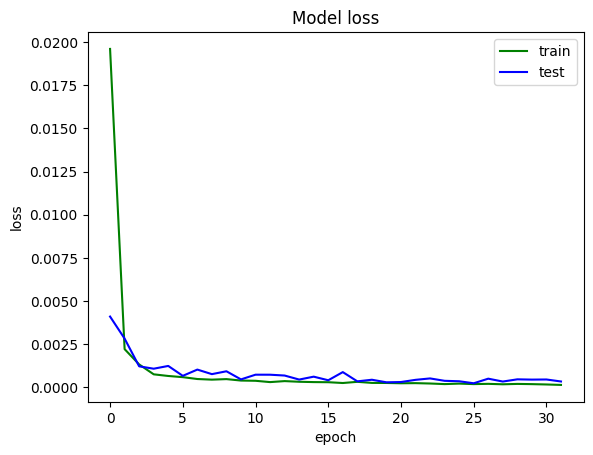

In [42]:
plt.plot(History.history['loss'], 'g')
plt.plot(History.history['val_loss'], 'b')
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='best')
# plt.ylim([0, 0.001])
plt.savefig('Model_loss.png')
plt.show()

In [43]:
test_data = scaled_data[training_data_len - 120:, :]
x_test = []
y_test = scaled_data[training_data_len:, -1]
for i in range(120, len(test_data)):
    x_test.append(test_data[i-120:i,:-1])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 7))

In [44]:
predictions = model.predict(x_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [45]:
pred = predictions.reshape((predictions.shape[0]))

In [46]:
rmse = np.sqrt(np.mean((pred - y_test) ** 2))
rmse

0.007672277621763672

In [50]:
tmp = pd.DataFrame(scaled_data[training_data_len:,:-1])
tmp[7] = predictions
tmp.shape

(668, 8)

In [51]:
res = minmax_scaler.inverse_transform(tmp.values)

In [52]:
tmp = pd.DataFrame(res)

In [53]:
tmp2 = df.iloc[training_data_len:, :]
tmp2['pred'] = tmp[7].tolist()

In [54]:
scaled_data.shape, tmp2.shape

((13363, 8), (668, 14))

In [55]:
tmp2

,YEAR,MO,DY,HR,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DWN,ALLSKY_KT,ALLSKY_SRF_ALB,QV2M,T2M,WS10M,tilt,date_time,pred
12695,2023,10,7,10,827.90,824.82,0.75,0.17,16.91,28.96,2.69,53.76,2023-10-07 10:00:00,53.699522
12696,2023,10,7,11,904.38,896.19,0.76,0.19,17.09,30.20,2.46,59.98,2023-10-07 11:00:00,59.741636
12697,2023,10,7,12,899.75,889.47,0.76,0.16,17.15,31.12,2.13,59.73,2023-10-07 12:00:00,59.381198
12698,2023,10,7,13,819.17,803.93,0.73,0.16,17.03,31.65,1.71,53.12,2023-10-07 13:00:00,52.998355
12699,2023,10,7,14,669.50,670.51,0.73,0.16,16.78,31.83,1.37,42.77,2023-10-07 14:00:00,43.144177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13358,2023,12,1,13,514.15,469.47,0.53,0.08,12.88,29.49,3.70,39.42,2023-12-01 13:00:00,39.606738
13359,2023,12,1,14,371.83,333.43,0.45,0.05,12.70,29.52,3.39,31.55,2023-12-01 14:00:00,31.559060
13360,2023,12,1,15,203.27,182.38,0.36,0.01,12.45,28.98,3.36,21.45,2023-12-01 15:00:00,21.508475
13361,2023,12,1,16,66.38,59.18,0.24,0.16,12.70,27.68,2.99,9.97,2023-12-01 16:00:00,10.469932


In [56]:
val = tmp2[(tmp2['date_time'] >= pd.Timestamp(2023, 12, 1, 0)) & (tmp2['date_time'] < pd.Timestamp(2024,12,2, 0))]

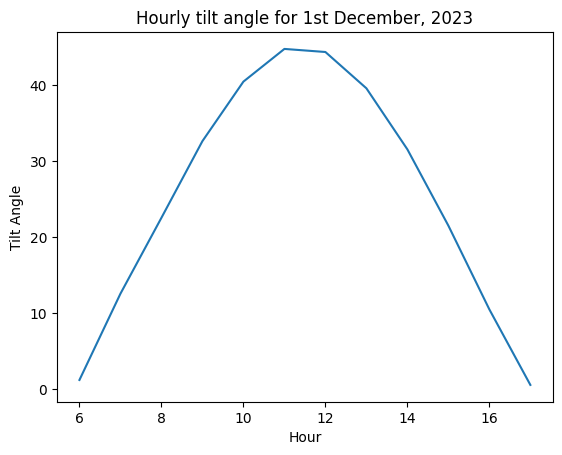

In [57]:
sns.lineplot(data=val, x='HR', y='pred', palette='sky_blue')
plt.xlabel('Hour')
plt.ylabel('Tilt Angle')
plt.title('Hourly tilt angle for 1st December, 2023')
plt.savefig('Hourly tilt angle.png')
plt.show()

In [58]:
x_total = []

for i in range(120,  len(scaled_data)):
    x_total.append(scaled_data[i-120:i, :-1])
x_total = np.array(x_total)

In [59]:
y_pred = model.predict(x_total)

414/414 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step


In [60]:
y_pred = y_pred.reshape((y_pred.shape[0]))

In [61]:
df_full = pd.DataFrame(scaled_data[120:,:-1])
df_full[7] = y_pred.tolist()

In [62]:
df_full

,0,1,2,3,4,5,6,7
0,0.015464,0.017198,0.379747,0.517241,0.307420,0.404417,0.190172,0.031088
1,0.057295,0.055970,0.430380,0.620690,0.329064,0.151307,0.266752,0.055300
2,0.234068,0.234012,0.658228,0.448276,0.339664,0.226707,0.227824,0.205610
3,0.415245,0.420729,0.784810,0.517241,0.347615,0.338157,0.209955,0.339273
4,0.560111,0.572945,0.848101,0.620690,0.323322,0.447322,0.207403,0.440482
...,...,...,...,...,...,...,...,...
13238,0.478675,0.442122,0.620253,0.275862,0.517668,0.538969,0.230377,0.464328
13239,0.346172,0.313288,0.518987,0.172414,0.509717,0.539731,0.210593,0.368579
13240,0.189239,0.170239,0.405063,0.034483,0.498675,0.526022,0.208679,0.249000
13241,0.061792,0.053564,0.253165,0.551724,0.509717,0.493019,0.185067,0.117667


In [63]:
tmp_val = minmax_scaler.inverse_transform(df_full.values)

In [64]:
df_full = pd.DataFrame(tmp_val)

In [65]:
df_full['date_time'] = df['date_time'].tolist()[120:]

In [66]:
df_full

,0,1,2,3,4,5,6,7,date_time
0,16.62,20.78,0.34,0.15,8.12,24.19,3.07,3.192933,2021-01-11 17:00:00
1,61.55,61.72,0.38,0.18,8.61,14.22,4.27,5.227951,2021-01-12 07:00:00
2,251.42,249.72,0.56,0.13,8.85,17.19,3.66,17.861515,2021-01-12 08:00:00
3,446.02,446.88,0.66,0.15,9.03,21.58,3.38,29.095874,2021-01-12 09:00:00
4,601.62,607.61,0.71,0.18,8.48,25.88,3.34,37.602489,2021-01-12 10:00:00
...,...,...,...,...,...,...,...,...,...
13238,514.15,469.47,0.53,0.08,12.88,29.49,3.70,39.606738,2023-12-01 13:00:00
13239,371.83,333.43,0.45,0.05,12.70,29.52,3.39,31.559060,2023-12-01 14:00:00
13240,203.27,182.38,0.36,0.01,12.45,28.98,3.36,21.508472,2023-12-01 15:00:00
13241,66.38,59.18,0.24,0.16,12.70,27.68,2.99,10.469934,2023-12-01 16:00:00


In [67]:
df_year = df_full[(df_full['date_time'] >= pd.Timestamp(2022,1,1,0)) & (df_full['date_time'] < pd.Timestamp(2023,1,1,0))]

In [68]:
df_year['month'] = df_year['date_time'].apply(lambda x: x.month)
df_year['day'] = df_year['date_time'].apply(lambda x: x.day)

In [69]:
monthly_tilt = df_year.groupby(['month']).mean()

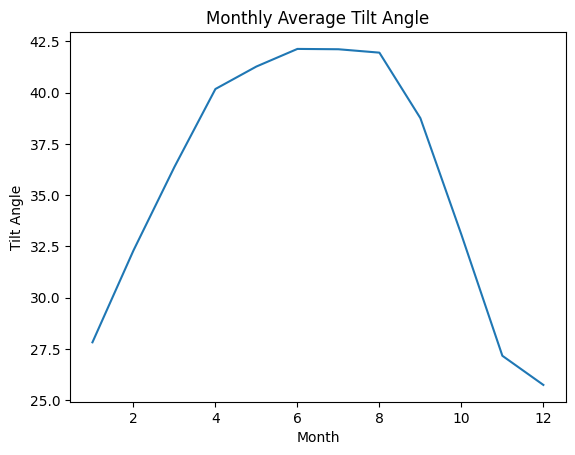

In [70]:
sns.lineplot(data=monthly_tilt, x='month', y=7, palette='sky_blue')
plt.xlabel('Month')
plt.ylabel('Tilt Angle')
plt.title('Monthly Average Tilt Angle')
plt.savefig('monthly tilt angle.png')
plt.show()

In [71]:
_df = df_year.groupby(['month', 'day']).mean()

In [72]:
months = ['Januaray', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

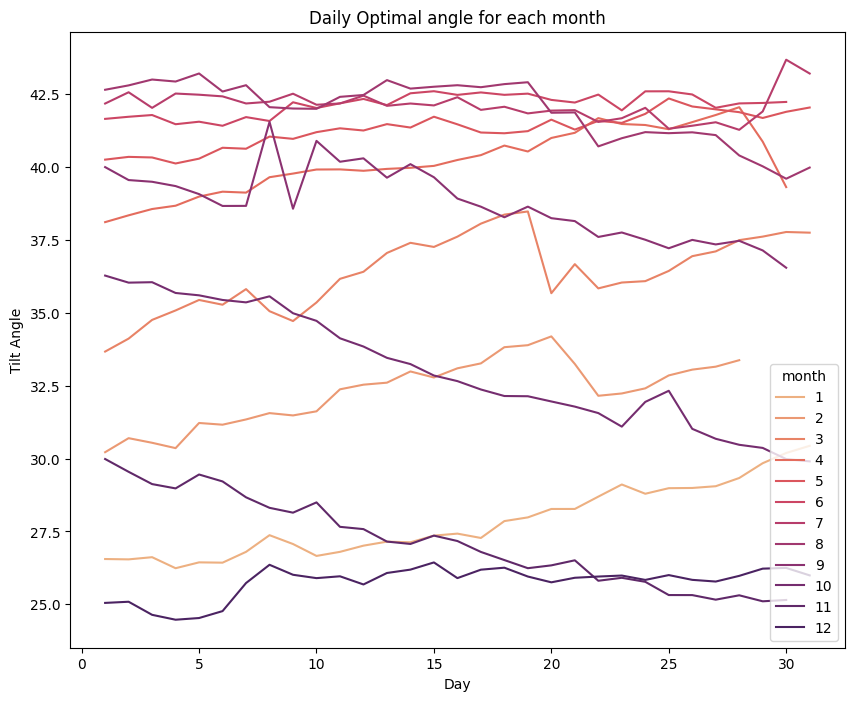

In [73]:
plt.figure(figsize=(10,8))
sns.lineplot(data=_df, y=7, x='day', hue='month', legend='full', palette='flare')
plt.xlabel('Day')
plt.ylabel('Tilt Angle')
plt.title('Daily Optimal angle for each month')
plt.savefig('daily optimal angle.png')
plt.show()